# Analysis of NTK Correction Term Scaling Laws

We analyze how the spectral radius of the NTK correction term scales with respect to:
- Network depth (L)
- Network width (M) 
- Input dimension (D)
- Number of samples (N)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

In [ ]:
PATH_TO_DATA = "/home/janis/STG3A/deeperorwider/experiments/data/large_ntk_corrections"
files = os.listdir(PATH_TO_DATA)
data = []

for f in files:
    if f.startswith("ntk_correction_"):
        d = np.load(os.path.join(PATH_TO_DATA, f), allow_pickle=True).item()
        data.append(d)

## Scaling Analysis by Configuration

In [ ]:
def plot_config_scaling(data, vary_param, fixed_params):
    # Get unique values for each fixed parameter
    unique_values = {p: sorted(list(set(d[p] for d in data))) for p in fixed_params}
    
    # Group data by fixed parameter combinations
    groups = {}
    slopes = []
    slopes_file = f"slopes_{vary_param}.txt"
    with open(slopes_file, 'w') as f:
        f.write(f"Slopes for {vary_param} scaling:\n")
        f.write("Configuration | Slope | R^2 | Points\n")
        f.write("-" * 50 + "\n")
    
    for d in data:
        key = tuple(d[p] for p in fixed_params)
        if key not in groups:
            groups[key] = []
        groups[key].append((d[vary_param], d['mean_spectral_radius'], d['std_spectral_radius']))

    # Filter and sort groups by number of points
    filtered_groups = {k:v for k,v in groups.items() if len(v) > 3}
    sorted_groups = sorted(filtered_groups.items(), key=lambda x: len(x[1]), reverse=True)

    if not sorted_groups:
        print(f"No configurations found with more than 3 points for {vary_param}")
        return

    # Create figure with subplots for each configuration
    n_configs = len(filtered_groups)
    if n_configs > 0:
        fig, axes = plt.subplots(n_configs, 1, figsize=(10, 4*n_configs))
        if n_configs == 1:
            axes = [axes]
    
        for idx, (config, values) in enumerate(sorted_groups[::5]):
            ax = axes[idx]
            sorted_values = sorted(values, key=lambda x: x[0])
            x = np.array([v[0] for v in sorted_values])
            y = np.array([v[1] for v in sorted_values])
            yerr = [v[2] for v in sorted_values]
            
            ax.errorbar(x, y, yerr=yerr, fmt='o', capsize=5, markersize=8)
            slope, intercept, r_value, p_value, std_err = linregress(np.log(x), np.log(y))
            slopes.append((config, slope, r_value**2, len(x)))
            x_line = np.array(sorted(x))
            ax.plot(x_line, np.exp(intercept) * x_line**slope, '--',
                    label=f'slope={slope:.2f}')
            
            # Save slope info to file
            config_str = ", ".join([f"{p}={v}" for p,v in zip(fixed_params, config)])
            with open(slopes_file, 'a') as f:
                f.write(f"{config_str} | {slope:.3f} | {r_value**2:.3f} | {len(x)}\n")
            
            config_str = ", ".join([f"{p}={v}" for p,v in zip(fixed_params, config)])
            ax.set_title(f'Spectral Radius vs {vary_param}\n{config_str}')
            ax.set_xlabel(vary_param)
            ax.set_ylabel('Spectral Radius')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.grid(True)
            ax.legend()

        plt.tight_layout()
        plt.show()

    return slopes

In [ ]:
# Plot scaling with respect to L for each (N,D,M) configuration
print("Analyzing depth (L) scaling for each configuration...")
L_slopes = plot_config_scaling(data, 'L', ['N', 'D_IN', 'M'])

Analyzing depth (L) scaling for each configuration...


In [ ]:
# Plot scaling with respect to D for each (N,L,M) configuration  
print("Analyzing input dimension (D) scaling for each configuration...")
D_slopes = plot_config_scaling(data, 'D_IN', ['N', 'L', 'M'])

Analyzing input dimension (D) scaling for each configuration...


Analyzing number of samples (N) scaling for each configuration...


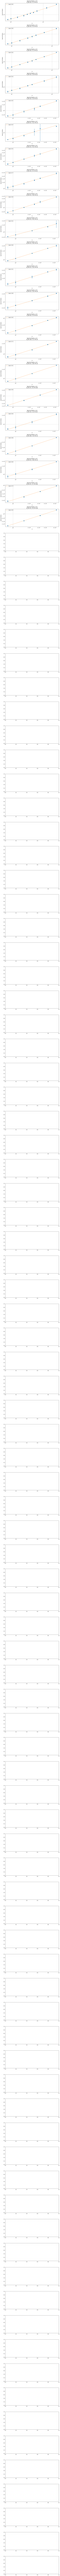

In [ ]:
# Plot scaling with respect to N for each (D,L,M) configuration
print("Analyzing number of samples (N) scaling for each configuration...")  
N_slopes = plot_config_scaling(data, 'N', ['D_IN', 'L', 'M'])

Plotting all points vs L...


/tmp/ipykernel_100965/3560114463.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


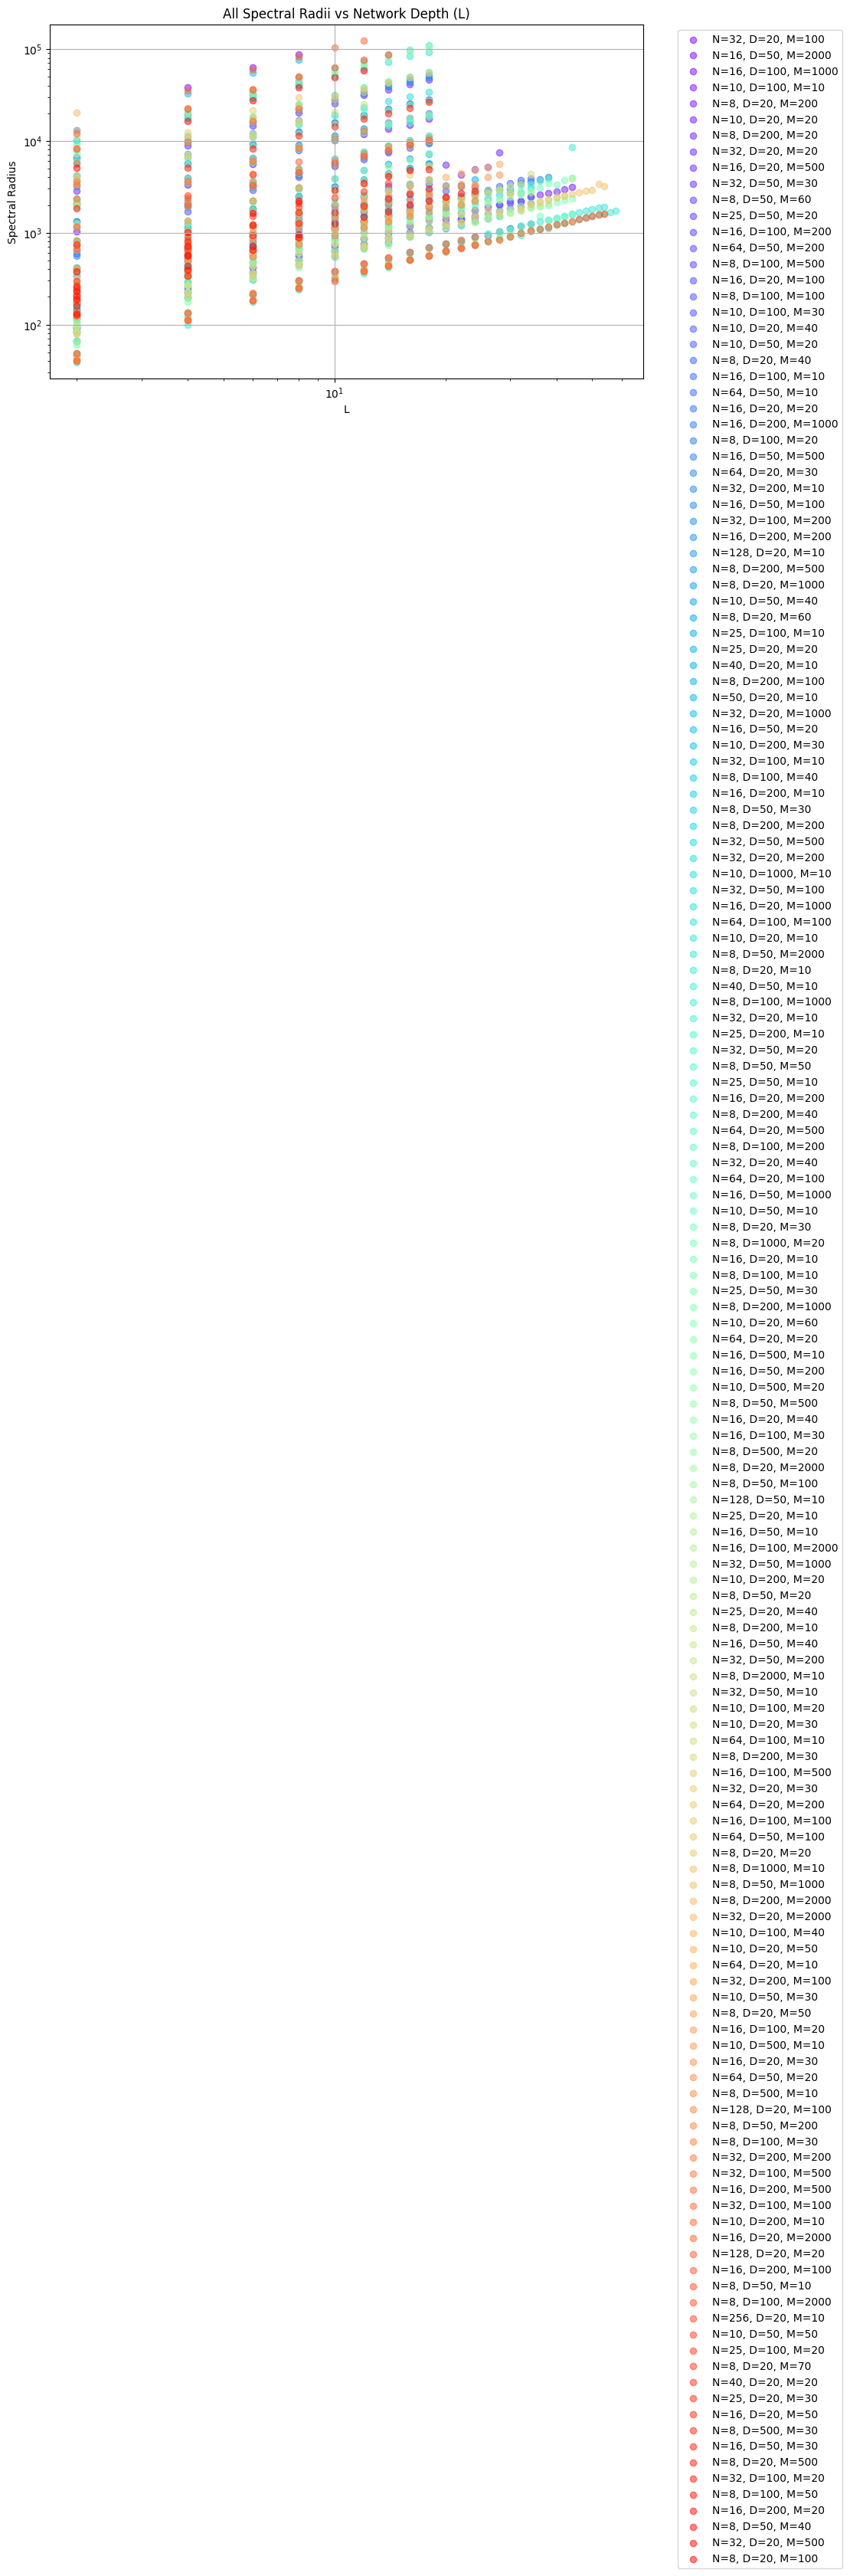

In [ ]:
# Plot all points vs L in a single plot
print("Plotting all points vs L...")
plt.figure(figsize=(10, 6))

# Create a unique color for each configuration
configs = [(d['N'], d['D_IN'], d['M']) for d in data]
unique_configs = list(set(configs))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_configs)))
config_to_color = dict(zip(unique_configs, colors))

for config in unique_configs:
    mask = [(d['N'], d['D_IN'], d['M']) == config for d in data]
    L_values_config = [d['L'] for d, m in zip(data, mask) if m]
    spectral_radii_config = [d['mean_spectral_radius'] for d, m in zip(data, mask) if m]
    plt.scatter(L_values_config, spectral_radii_config, 
               color=config_to_color[config], alpha=0.5,
               label=f'N={config[0]}, D={config[1]}, M={config[2]}')

plt.xlabel('L')
plt.ylabel('Spectral Radius')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.title('All Spectral Radii vs Network Depth (L)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Plotting all points vs D_IN...


/tmp/ipykernel_100965/746665170.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


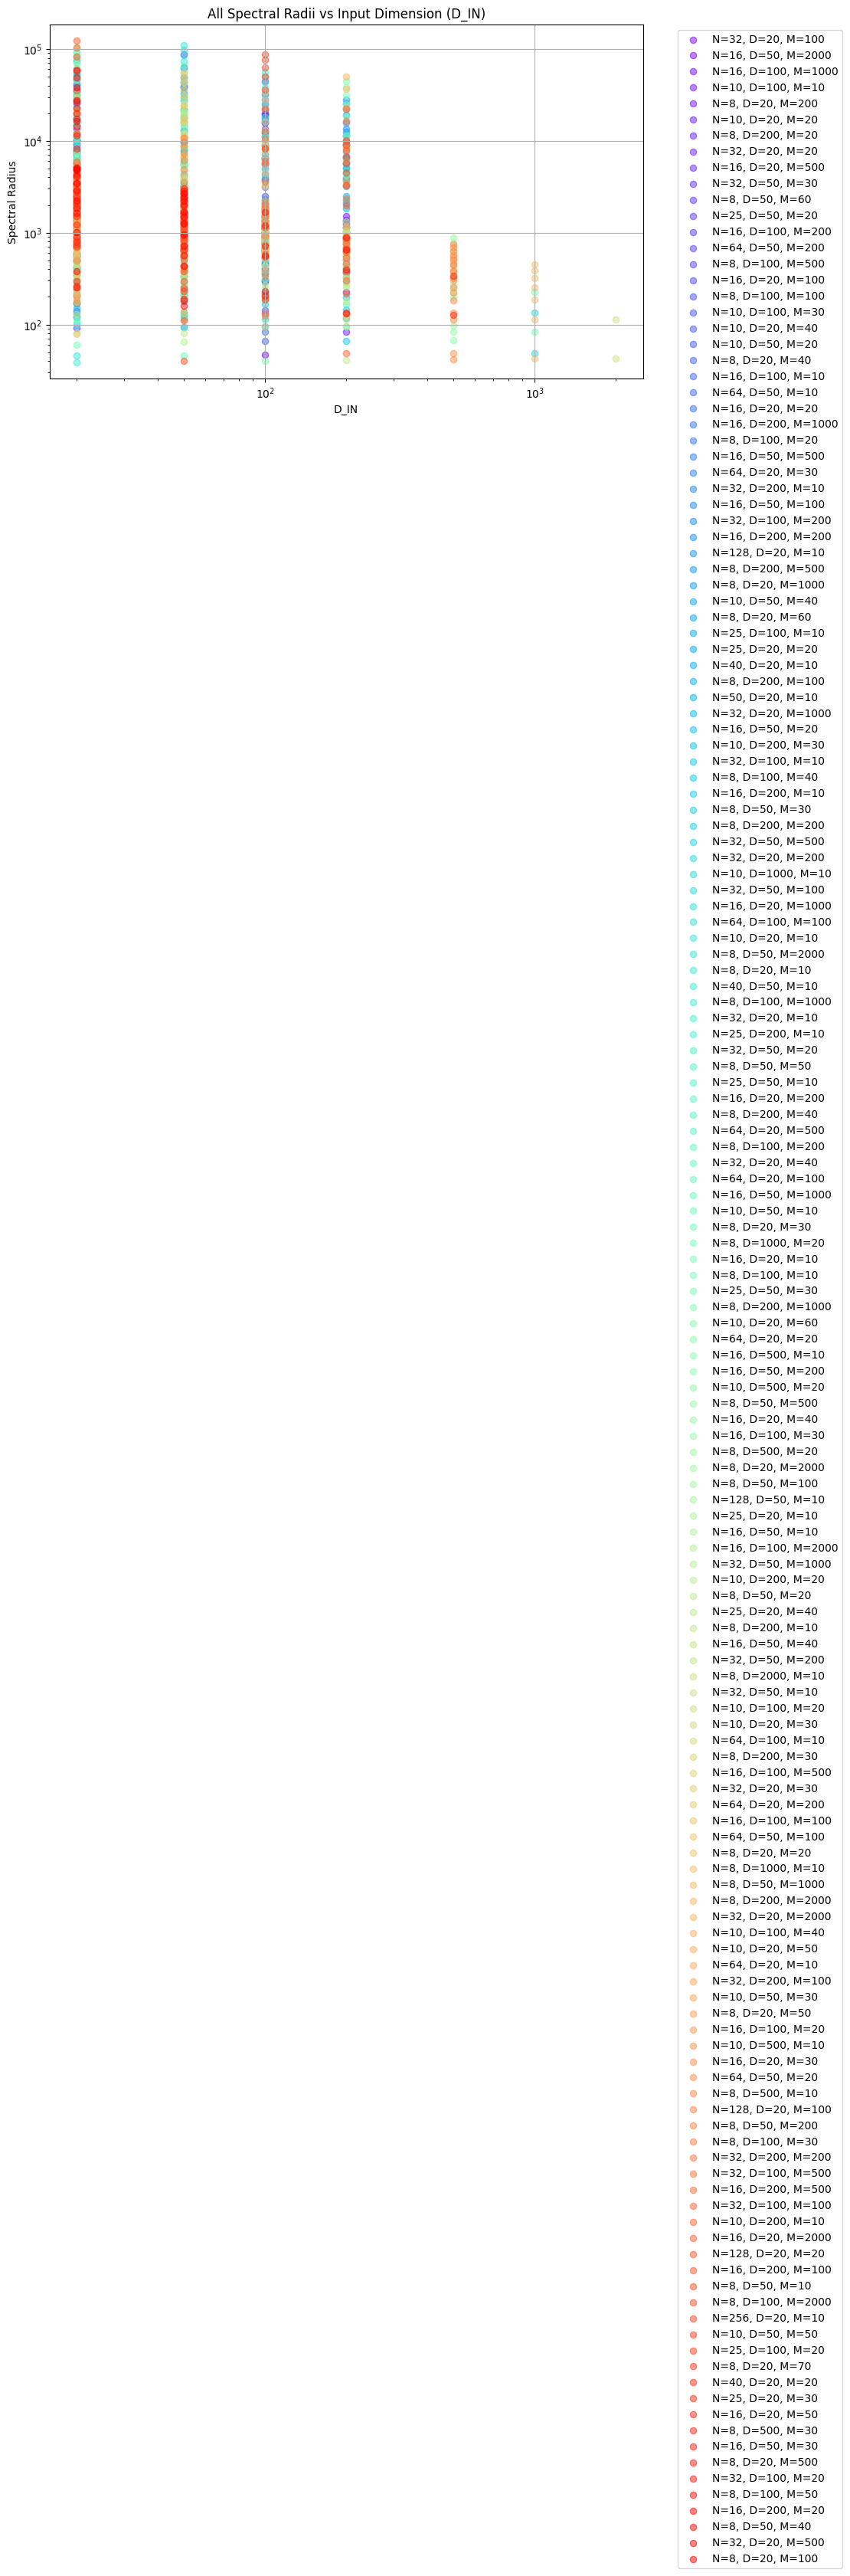

In [ ]:
# Plot all points vs D_IN in a single plot with same coloring scheme
print("Plotting all points vs D_IN...")
plt.figure(figsize=(10, 6))

for config in unique_configs:
    mask = [(d['N'], d['D_IN'], d['M']) == config for d in data]
    D_values_config = [d['D_IN'] for d, m in zip(data, mask) if m]
    spectral_radii_config = [d['mean_spectral_radius'] for d, m in zip(data, mask) if m]
    plt.scatter(D_values_config, spectral_radii_config, 
               color=config_to_color[config], alpha=0.5,
               label=f'N={config[0]}, D={config[1]}, M={config[2]}')

plt.xlabel('D_IN')
plt.ylabel('Spectral Radius')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.title('All Spectral Radii vs Input Dimension (D_IN)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Plotting all points vs N...


/tmp/ipykernel_100965/1302541909.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


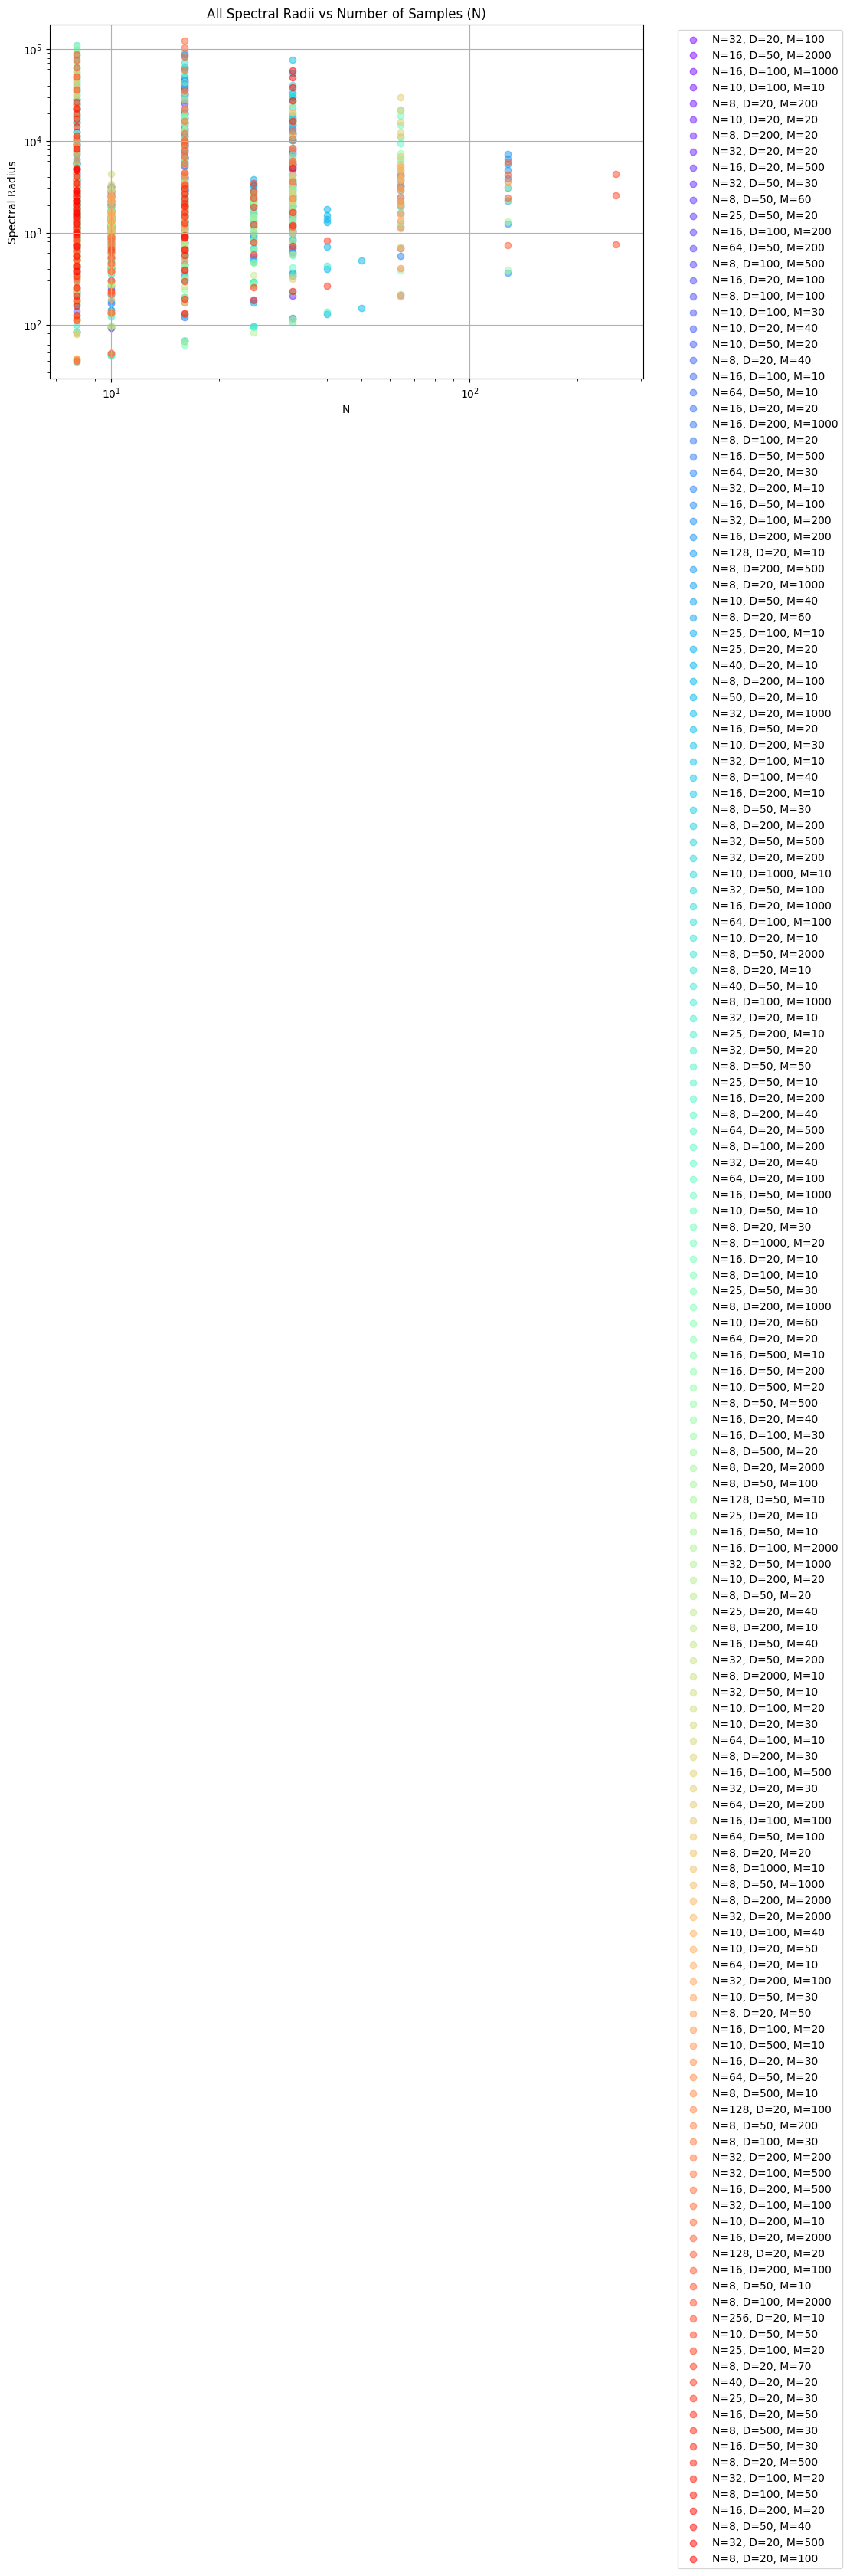

In [ ]:
# Plot all points vs N in a single plot with same coloring scheme
print("Plotting all points vs N...")
plt.figure(figsize=(10, 6))

for config in unique_configs:
    mask = [(d['N'], d['D_IN'], d['M']) == config for d in data]
    N_values_config = [d['N'] for d, m in zip(data, mask) if m]
    spectral_radii_config = [d['mean_spectral_radius'] for d, m in zip(data, mask) if m]
    plt.scatter(N_values_config, spectral_radii_config, 
               color=config_to_color[config], alpha=0.5,
               label=f'N={config[0]}, D={config[1]}, M={config[2]}')

plt.xlabel('N')
plt.ylabel('Spectral Radius')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.title('All Spectral Radii vs Number of Samples (N)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Perform multivariate linear regression in log space
print("\nMultivariate Linear Regression Analysis in Log Space:")
X = np.array([[np.log(d['L']), np.log(d['D_IN']), np.log(d['N']), np.log(d['M'])] for d in data])
y = np.array([np.log(d['mean_spectral_radius']) for d in data])

reg = LinearRegression().fit(X, y)

print("\nRegression coefficients:")
print(f"L coefficient: {reg.coef_[0]:.3f}")
print(f"D_IN coefficient: {reg.coef_[1]:.3f}")
print(f"N coefficient: {reg.coef_[2]:.3f}")
print(f"M coefficient: {reg.coef_[3]:.3f}")
print(f"Intercept: {reg.intercept_:.3f}")
print(f"R² score: {reg.score(X, y):.3f}")

# The model is: log(spectral_radius) = a*log(L) + b*log(D_IN) + c*log(N) + d*log(M) + intercept
# Therefore: spectral_radius ∝ L^a * D_IN^b * N^c * M^d

print("\nThis means the spectral radius scales approximately as:")
print(f"spectral_radius ∝ L^{reg.coef_[0]:.3f} * D_IN^{reg.coef_[1]:.3f} * N^{reg.coef_[2]:.3f} * M^{reg.coef_[3]:.3f}")


Multivariate Linear Regression Analysis in Log Space:

Regression coefficients:
L coefficient: 1.171
D_IN coefficient: 0.047
N coefficient: 0.900
M coefficient: 1.009
Intercept: -1.463
R² score: 0.994

This means the spectral radius scales approximately as:
spectral_radius ∝ L^1.171 * D_IN^0.047 * N^0.900 * M^1.009
